In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

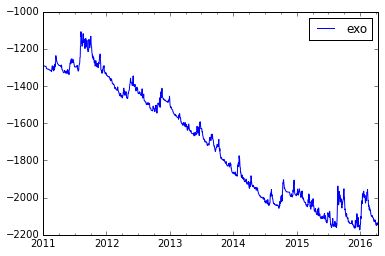

In [4]:
d.plot()


In [5]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

<h1>Simple entry and exit rules based on MA crossing</h1>

In [6]:
# Look deeper
px = d.exo.ix['2015':]
slow_ma = px.rolling(50).mean()
fast_ma = px.rolling(20).mean()

# Median based trailing stop
trailing_stop = px.rolling(10).median().shift(1)

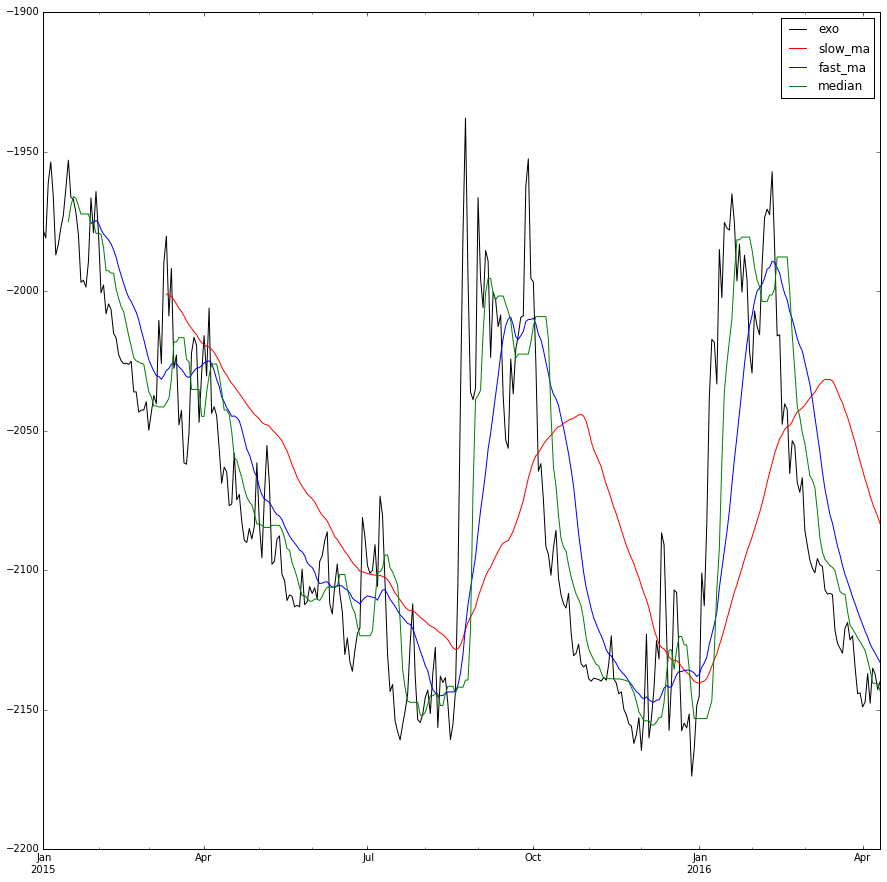

In [7]:
figsize(15, 15)
px.plot(c='black', label='exo')
slow_ma.plot(c='r', label='slow_ma')
fast_ma.plot(c='b', label='fast_ma')
trailing_stop.plot(c='g', label='median')
legend()

# Class based strategy

* Enter short when fast MA crosses down slow MA
* Exit when fast MA crosses up slow MA + median trailing stop


In [8]:
class StrategyMACrossTrail(StrategyBase):
    def __init__(self):
        # Initialize parent class
        super().__init__()
        
        # Define system's name
        self.name = 'MA Crossing with trailing stop'
        
        # Define optimized params
        self.opts = [
            #OptParam(name, default_value, min_value, max_value, step)
            OptParam('SlowMAPeriod', 50, 50, 100, 2),
            OptParam('FastMAPeriod', 10, 10, 50, 2),
            OptParam('MedianPeriod', 15, 5, 20, 5)
        ]
        
        self.initialize()
        
    def initialize(self):
        #
        #  Loading EXO quotes from .mat file
        #
        strategyname = 'strategy_270225'
        self.data, info = matlab.loaddata('../mat/'+strategyname+'.mat')
        
    def calculate(self, params=None):
        #        
        #
        #  Params is a tripple like (50, 10, 15), where:
        #   50 - slow MA period
        #   10 - fast MA period
        #   15 - median period
        #
        #  On every iteration of swarming algorithm, parameter set will be different.
        #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
        #       
        
        if params is None:
            # Return default parameters
            period_slow, period_fast, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            period_slow, period_fast, period_median = params
        
        #
        #
        # Indicator calculation
        #
        
        # Defining EXO price
        px = self.data.exo        
        slow_ma = px.rolling(period_slow) .mean()
        fast_ma = px.rolling(period_fast).mean()
        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)        
    
        # Enry/exit rules
        short_entry = CrossDown(fast_ma, slow_ma)
        short_exit = (CrossUp(fast_ma, slow_ma) ) | (CrossUp(px, trailing_stop))
        
        # Backtesting routine
        direction = -1
        pl, inposition = backtester.backtest(d, short_entry, short_exit, direction )
        equity, stats = backtester.stats(pl, inposition)
        
        return equity, stats
        

<h1>Backtest results</h2>

In [9]:
# Initiate the strategy
strategy = StrategyMACrossTrail()

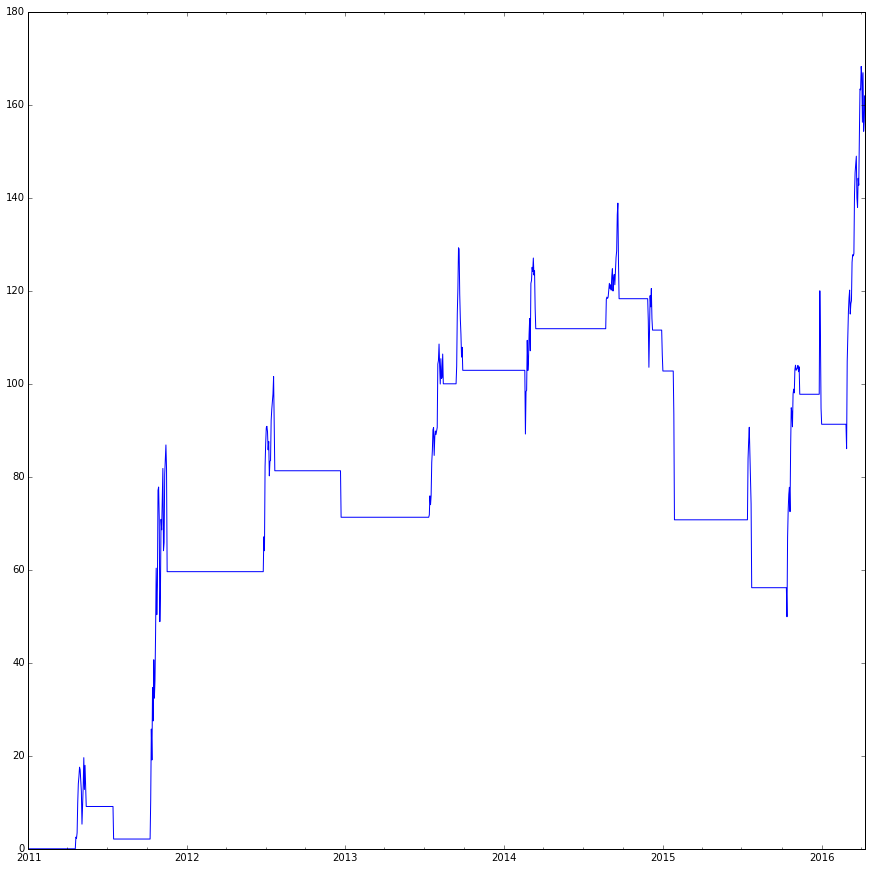

In [10]:
# We can do a single run of strategy with default params
equity, stats = strategy.calculate()
equity.plot()

In [11]:
# Calculate swarm of parameters
swarm = strategy.run_swarm()

In [12]:
# Slice first 5 elements
swarm[5:]

[[(50, 12, 15),
  {'avg': 10.933333333333348,
   'count': 15,
   'maxdd': -88.049999999999955,
   'netprofit': 164.00000000000023,
   'std': 29.828932636321749,
   'winrate': 0.5333333333333333},
  None],
 [(50, 14, 5),
  {'avg': 7.1617647058823666,
   'count': 17,
   'maxdd': -78.600000000000136,
   'netprofit': 121.75000000000023,
   'std': 22.633249418471785,
   'winrate': 0.6470588235294118},
  None],
 [(50, 14, 10),
  {'avg': 9.5735294117647065,
   'count': 17,
   'maxdd': -76.850000000000364,
   'netprofit': 162.75,
   'std': 29.753359264850261,
   'winrate': 0.5294117647058824},
  None],
 [(50, 14, 15),
  {'avg': 5.8375000000000057,
   'count': 16,
   'maxdd': -103.00000000000023,
   'netprofit': 93.400000000000091,
   'std': 29.409833070760516,
   'winrate': 0.4375},
  None],
 [(50, 16, 5),
  {'avg': 16.164285714285693,
   'count': 14,
   'maxdd': -51.150000000000091,
   'netprofit': 226.29999999999973,
   'std': 29.031672535423795,
   'winrate': 0.7857142857142857},
  None],
 